# Save figures for publication 
Author: Pia Rautenstrauch

Date: 2024-01-15

Abbreviation for Extended treatment-control use-case: ETCU

## Requirements
- [x] Fontsize: > 7 - 12
- [x] Font type: Arial
- [x] Linewidth 0.25pt-1pt (defaults to 1)
- [x] dpi: 600


## Other modifications
- [x] random order of plotting of colors in umap (https://github.com/scverse/scanpy/issues/891)

Anaconda environment: scib_v1.0.1_min


In [1]:
# Imports
import os
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import scib
import scanpy as sc
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import rc

During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
scib.__version__

'1.0.1'

In [4]:
# From https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [5]:
sc.set_figure_params(dpi_save=600, dpi=100, transparent=True, format='png', fontsize=18, figsize=(200*px, 140*px))

In [6]:
plt.rcParams['figure.figsize']

[2.7777777777777777, 1.9444444444444444]

In [7]:
# overwrite scanpy/matplotlib default font: chose: Arial

In [8]:
# Need to remove chached fonts

In [9]:
! rm ~/.cache/matplotlib -rf

In [10]:
font_dirs = ["miniconda3/envs/scib_v1.0.1_min/fonts"]  # The path to the custom font file.
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

In [11]:
# change font
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

In [12]:
# clr transform protein data
# Source: https://github.com/theislab/scanpy/issues/1208
# Slightly modified to account for adata properties
def clr_transform(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    seurat_clr = (lambda x: np.log1p(x/ (np.exp(np.sum(np.log1p(x[x > 0]) / x.shape[1])))))

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.todense() if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [13]:
# Publication figures

In [14]:
# List of identifiers of trained models
models = ['BAVAE_sample_100_extended_use_case_x25', 'VAE_100_extended_use_case']


BAVAE_sample_100_extended_use_case_x25


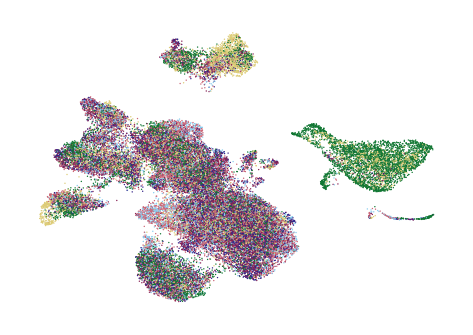

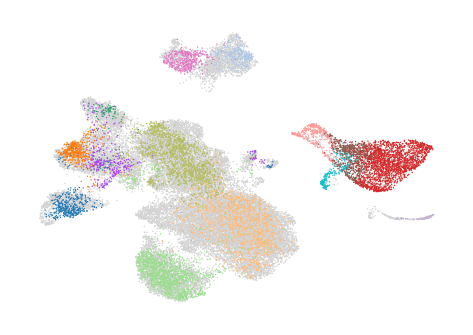

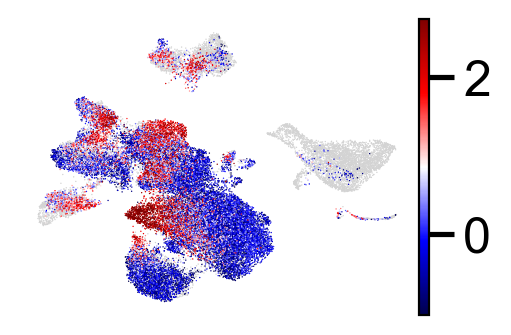

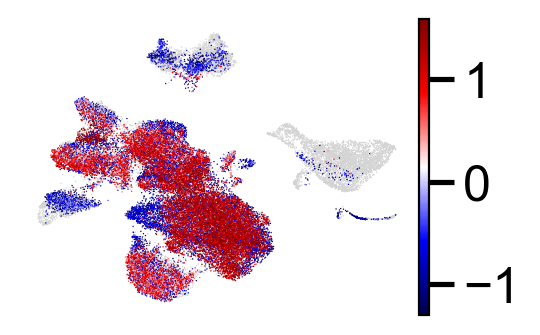

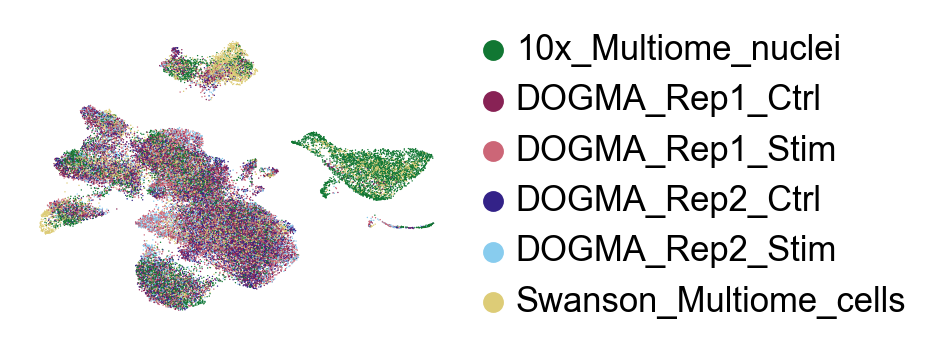

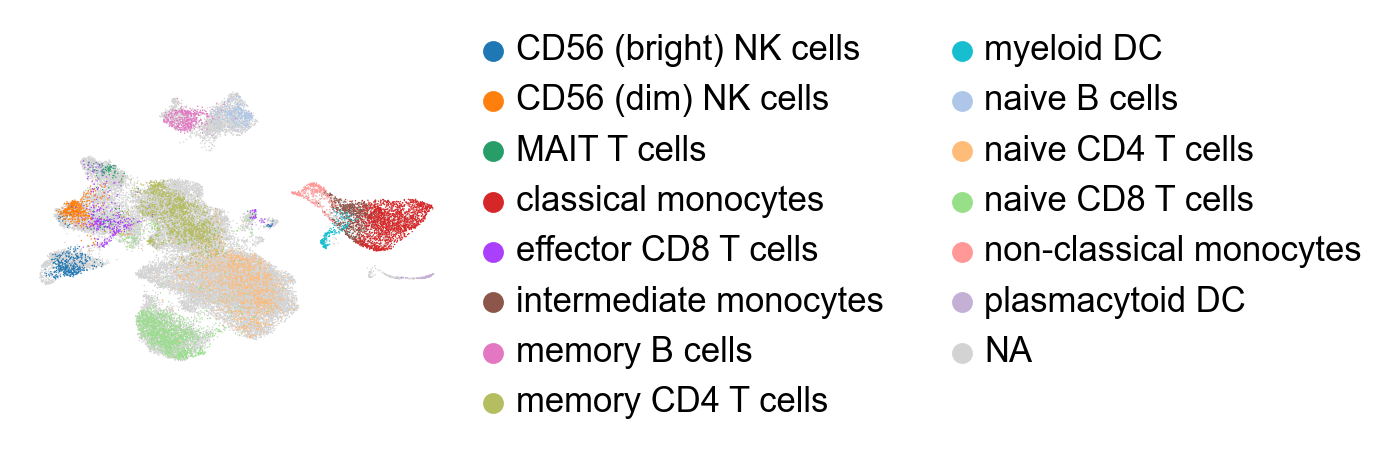

VAE_100_extended_use_case


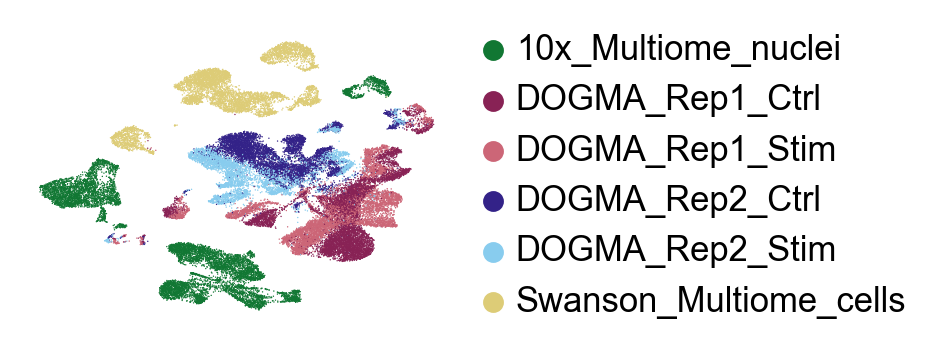

In [15]:
# Collect computed scores, nested dict is simple to convert to pd.DataFrame
score_dict = {}
for model in models:
    print(model)
    # Read embeddings
    embedding = ad.read_h5ad('./../Predictions/{}.prediction.h5ad'.format(model))
    embedding.obs['DOGMA_rep'] = embedding.obs['sample'].apply(lambda x: 'DOGMA_Rep1' if 'DIG' in x else 'DOGMA_Rep2' if 'LLL' in x else np.nan).astype('category')
    embedding.obs['DOGMA_cond'] = embedding.obs['sample'].apply(lambda x: 'DOGMA_Ctrl' if 'CTRL' in x else 'DOGMA_Stim' if 'STIM' in x else np.nan).astype('category')
    # gunzip if required
    DOGMA_adata = sc.read_h5ad("./../../../data/derived/Mimitou2021/DOGMA_seq/preprocessed_DOGMA.h5ad")

    features = pd.read_csv("./../../../data/original/Mimitou2021/DOGMA_seq/DIG_CTRL/ADT/" +  "features.tsv.gz", header=None, names=["protein_names"]).set_index('protein_names')
    protein = sc.AnnData(DOGMA_adata.obsm["ADT"], obs=DOGMA_adata.obs, var=features)
    clr_transform(protein)
    protein.X = np.array(protein.X)
    sc.pp.scale(protein)
    parsed_protein_names = protein.var.index.tolist()
    combined_protein = protein.X
    for i, p in enumerate(parsed_protein_names):
        protein.obs["{} observed".format(p)] = combined_protein[:, i]
    protein.obs.index = protein.obs.index.map(lambda x: x + '_treatment_control_use_case')
    embedding.obs = embedding.obs.merge(protein.obs, left_index=True, right_index=True, how='left')
    
    # use colorblind friendly colors for variables
    embedding.uns['DOGMA_rep_colors'] = ['#0173b2', '#de8f05']
    embedding.uns['DOGMA_cond_colors'] = ['#029e73', '#d55e00']
    embedding.uns['sample_colors'] = ['#117733', '#882255', '#CC6677', '#332288', '#88CCEE',  '#DDCC77']
    
    # Random order of plotting
    embedding = sc.pp.subsample(embedding, fraction=1., copy=True)
    
    # rename variables
    embedding.obs['sample'] = embedding.obs['sample'].map(lambda x: {'DOGMA_DIG_CTRL': 'DOGMA_Rep1_Ctrl', 'DOGMA_DIG_STIM': 'DOGMA_Rep1_Stim', 'DOGMA_LLL_CTRL': 'DOGMA_Rep2_Ctrl', 'DOGMA_LLL_STIM': 'DOGMA_Rep2_Stim', '10k_sorted_nuclei': '10x_Multiome_nuclei', 'perm_cells': 'Swanson_Multiome_cells'}[x])
    embedding.obs.rename(columns={'celltype': 'cell type'}, inplace=True)
    if model == 'BAVAE_sample_100_extended_use_case_x25':
        ### Save UMAP visualization as png 
        sc.pl.umap(
            embedding,
            color=['sample'],
            size=1,
            frameon=False,
            ncols=1,
            wspace=0,
            save="_{}_ETCU_sample.png".format(model),
            legend_loc=None,
            title=[''],
            #legend_fontsize='x-small'
        )

        ### Save UMAP visualization as png 
        sc.pl.umap(
            embedding,
            color=['cell type'],
            size=1,
            frameon=False,
            ncols=1,
            wspace=0,
            save="_{}_ETCU_cell_type.png".format(model),
            legend_loc=None,
            title=[''],
            #legend_fontsize='x-small'
        )

        ### Save UMAP visualization as png 
        sc.pl.umap(
            embedding,
            color=['CD69 observed'],
            size=1,
            frameon=False,
            ncols=1,
            wspace=0,
            save="_{}_ETCU_CD69.png".format(model),
            legend_loc=None,
            title=[''],
            vmin="p1",
            vmax="p99",
            color_map="seismic",
            #legend_fontsize='x-small'
        )

        ### Save UMAP visualization as png 
        sc.pl.umap(
            embedding,
            color=['CD3-2 observed'],
            size=1,
            frameon=False,
            ncols=1,
            wspace=0,
            save="_{}_ETCU_CD32.png".format(model),
            legend_loc=None,
            title=[''],
            vmin="p1",
            vmax="p99",
            color_map="seismic",
            #legend_fontsize='x-small'
        )


        ### Save UMAP visualization as png 
        sc.pl.umap(
                embedding,
                color=['sample'],
                size=1,
                frameon=False,
                ncols=1,
                save="_{}_ETCU_sample_legend.png".format(model),
                legend_fontsize='x-small',
                title=['']
        )

        sc.pl.umap(
                embedding,
                color=['cell type'],
                size=1,
                frameon=False,
                ncols=1,
                save="_{}_ETCU_cell_type_legend.png".format(model),
                legend_fontsize='x-small',
                title=['']
        )
    
    else:
        sc.pl.umap(
            embedding,
            color=['sample'],
            size=1,
            frameon=False,
            ncols=1,
            save="_{}_ETCU_sample_legend.png".format(model),
            legend_fontsize='x-small',
            title=['']
    )



In [16]:
# Kernel restart

In [1]:
# iLISI figures

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scib
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import matplotlib.font_manager as fm


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use( 'seaborn-colorblind')

In [5]:
# Need to remove chached fonts

In [6]:
! rm ~/.cache/matplotlib -rf

In [7]:
font_dirs = ["miniconda3/envs/scib_v1.0.1_min/fonts"]  # The path to the custom font file.
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

In [8]:
# change font
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

In [9]:
plt.rcParams['figure.figsize'] = [6.0*4/5, 4.0*4/5]

In [10]:
iLISI = pd.read_csv("./../Evaluation/batch_removal_scores_publication_r1_20240125.csv", index_col=0)


In [11]:
iLISI

,iLISI_sample,iLISI_DOGMA_replicate,iLISI_DOGMA_condition,asw_label_10k_sorted_nuclei,nmi_10k_sorted_nuclei,Model
BAVAE_sample_100_extended_use_case,0.378749,0.803639,0.744849,0.615471,0.812651,BAVAE_sample_100_extended_use_case
VAE_100_extended_use_case,0.002813,0.002236,0.079759,0.622500,0.840412,VAE_100_extended_use_case
BAVAE_sample_100_extended_use_case_x5,0.465444,0.838364,0.765689,0.614223,0.775028,BAVAE_sample_100_extended_use_case_x5
BAVAE_sample_100_extended_use_case_x10,0.499180,0.852161,0.777670,0.605701,0.760488,BAVAE_sample_100_extended_use_case_x10
BAVAE_sample_100_extended_use_case_x25,0.518073,0.861687,0.825707,0.608753,0.812367,BAVAE_sample_100_extended_use_case_x25
BAVAE_sample_100_extended_use_case_x50,0.525662,0.855177,0.841465,0.606339,0.791595,BAVAE_sample_100_extended_use_case_x50
BAVAE_sample_100_extended_use_case_x100,0.528294,0.856856,0.842479,0.595586,0.773547,BAVAE_sample_100_extended_use_case_x100


In [12]:
Liam_sample = pd.DataFrame({
    'sample': [iLISI.loc['BAVAE_sample_100_extended_use_case']['iLISI_sample'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x5']['iLISI_sample'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x10']['iLISI_sample'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x25']['iLISI_sample'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x50']['iLISI_sample'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x100']['iLISI_sample']
                     ],
    'replicate': [iLISI.loc['BAVAE_sample_100_extended_use_case']['iLISI_DOGMA_replicate'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x5']['iLISI_DOGMA_replicate'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x10']['iLISI_DOGMA_replicate'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x25']['iLISI_DOGMA_replicate'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x50']['iLISI_DOGMA_replicate'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x100']['iLISI_DOGMA_replicate']
                     ],
    'condition': [iLISI.loc['BAVAE_sample_100_extended_use_case']['iLISI_DOGMA_condition'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x5']['iLISI_DOGMA_condition'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x10']['iLISI_DOGMA_condition'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x25']['iLISI_DOGMA_condition'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x50']['iLISI_DOGMA_condition'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x100']['iLISI_DOGMA_condition']
                     ],
    'asw_label': [iLISI.loc['BAVAE_sample_100_extended_use_case']['asw_label_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x5']['asw_label_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x10']['asw_label_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x25']['asw_label_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x50']['asw_label_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x100']['asw_label_10k_sorted_nuclei']
                     ], 
    'nmi': [iLISI.loc['BAVAE_sample_100_extended_use_case']['nmi_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x5']['nmi_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x10']['nmi_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x25']['nmi_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x50']['nmi_10k_sorted_nuclei'],
                      iLISI.loc['BAVAE_sample_100_extended_use_case_x100']['nmi_10k_sorted_nuclei']
                     ], 

   }, index=['x1', 'x5', 'x10', 'x25', 'x50', 'x100'])

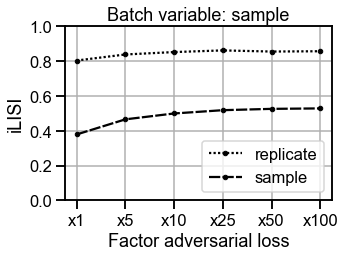

In [13]:
Liam_sample['replicate'].plot(marker='.', linestyle=(0, (1,1)), ylim=(0,1), color='black')
Liam_sample['sample'].plot(marker='.', linestyle=(0,(5, 1)), ylim=(0,1), color='black')

plt.title('Batch variable: sample')
plt.legend(loc='lower right')
plt.xlabel('Factor adversarial loss')
plt.ylabel('iLISI')
plt.grid()
x = [0, 1, 2, 3, 4, 5]
# labels for x-asix
labels = Liam_sample.index.values.tolist()
# setting x-axis values
plt.xticks(x, labels)
plt.savefig('./figures/ETCU_Liam_sample_metrics_batch.png', bbox_inches='tight', transparent=True, dpi=600)

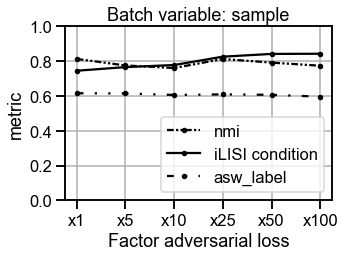

In [14]:
Liam_sample['nmi'].plot(marker='.', linestyle=(0, (3, 1, 1, 1, 1, 1)), ylim=(0,1), color='black')
Liam_sample['condition'].plot(marker='.', linestyle='solid', ylim=(0,1), color='black', label='iLISI condition')
Liam_sample['asw_label'].plot(marker='.', linestyle=(0, (3, 5, 1, 5, 1, 5)), ylim=(0,1), color='black')

plt.title('Batch variable: sample')
plt.legend(loc='lower right')
plt.xlabel('Factor adversarial loss')
plt.ylabel('metric')
plt.grid()
x = [0, 1, 2, 3, 4, 5]
# labels for x-asix
labels = Liam_sample.index.values.tolist()
# setting x-axis values
plt.xticks(x, labels)
plt.savefig('./figures/ETCU_Liam_sample_metrics_label.png', bbox_inches='tight', transparent=True, dpi=600)